In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box
import fiona
import os
import sklearn
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
from imblearn.over_sampling import RandomOverSampler
from folium.features import GeoJsonTooltip
from sklearn.preprocessing import label_binarize, LabelEncoder, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV

DATA COLLECTING

In [3]:
gdb_path = "D:/college_dump/PKL/PREDIKSI EMISI KARBON/Banyumas/KAB BANYUMAS/2022_RBI25K_KAB_BANYUMAS_KUGI50_20221231.gdb"

banyumas_shp = "D:/college_dump/PKL/PREDIKSI EMISI KARBON/indonesiaSHPLevel3/gadm41_IDN_3.shp"
banyumas_kab = gpd.read_file(banyumas_shp)
banyumas_kab = banyumas_kab[banyumas_kab["NAME_2"] == "Banyumas"].to_crs(epsg=32749)
banyumas_boundary = banyumas_kab.dissolve(by="NAME_2")

In [4]:
layer_hijau = [
    "HUTANLAHANTINGGI_AR_25K",
    "HUTANLAHANRENDAH_AR_25K",
    "HERBADANRUMPUT_AR_25K",
    "HUTANTANAMAN_AR_25K"
]

list_gdf = []
for layer in layer_hijau:
    gdf = gpd.read_file(gdb_path, layer=layer)
    list_gdf.append(gdf)

area_hijau = gpd.GeoDataFrame(pd.concat(list_gdf, ignore_index=True), crs=list_gdf[0].crs).to_crs(epsg=32749)


c:\Users\Adel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [5]:
layer_bangunan = ["PERUMAHAN_AR_25K", "PERMUKIMAN_AR_25K"]
bangunan_list = []

for layer in layer_bangunan:
    try:
        gdf = gpd.read_file(gdb_path, layer=layer)
        bangunan_list.append(gdf)
        print(f"✅ Berhasil baca layer: {layer} ({len(gdf)} fitur)")
    except Exception as e:
        print(f"⚠️ Gagal membaca layer {layer}: {e}")

# Gabung jadi 1 dataframe
bangunan = gpd.GeoDataFrame(
    pd.concat(bangunan_list, ignore_index=True),
    crs=bangunan_list[0].crs
).to_crs(epsg=32749)

jalan = gpd.read_file(gdb_path, layer="JALAN_LN_25K").to_crs(epsg=32749)

✅ Berhasil baca layer: PERUMAHAN_AR_25K (291 fitur)
✅ Berhasil baca layer: PERMUKIMAN_AR_25K (4405 fitur)


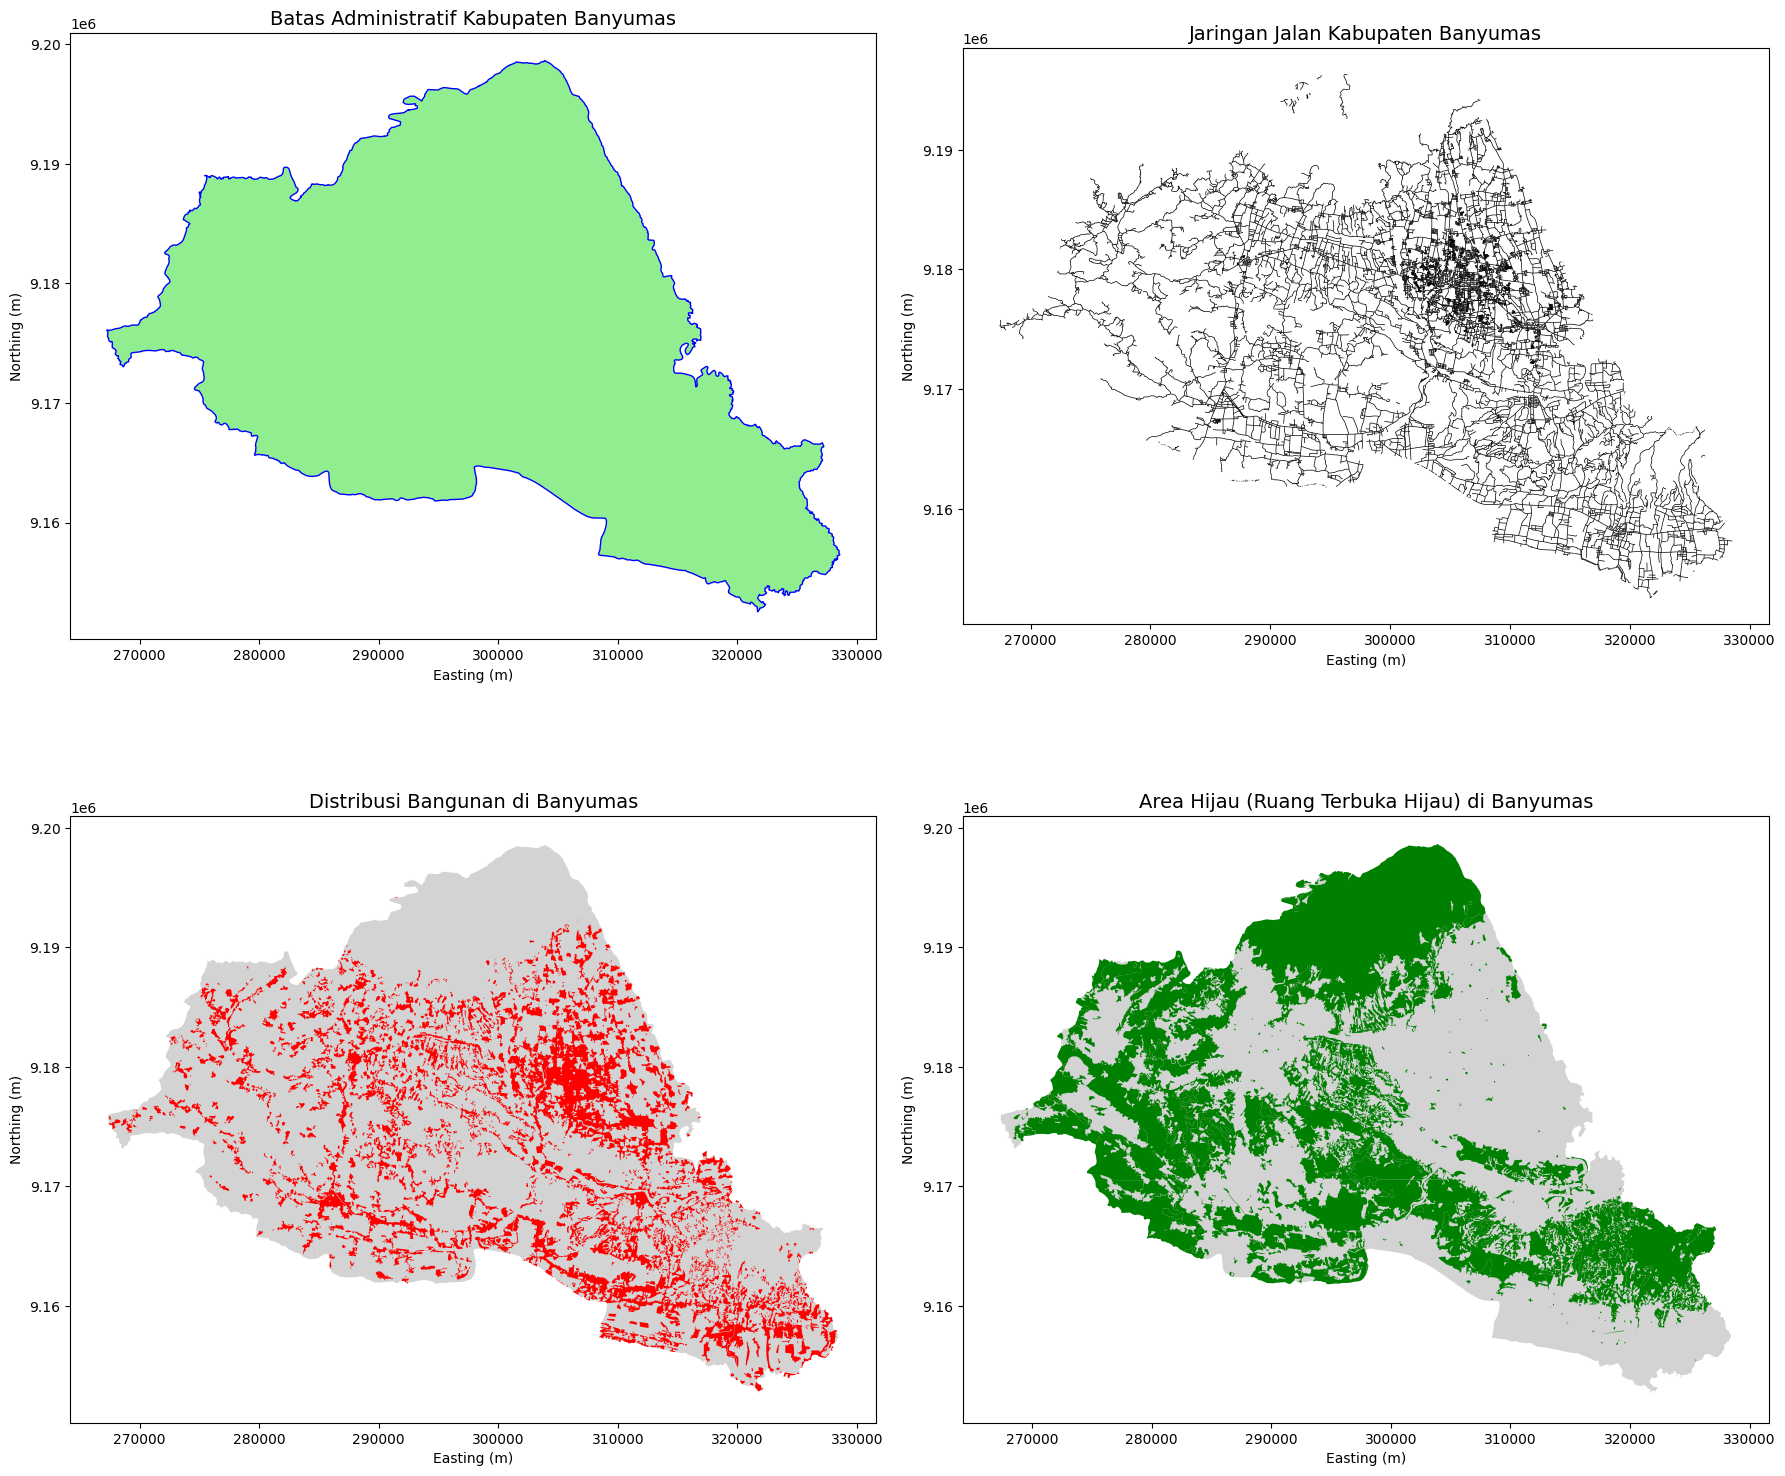

In [ ]:
# Clip ke batas banyumas
jalan_bms = gpd.clip(jalan, banyumas_boundary)
bangunan_bms = gpd.clip(bangunan, banyumas_boundary)
area_hijau_bms = gpd.clip(area_hijau, banyumas_boundary)

fig, axs = plt.subplots(2, 2, figsize=(18, 16))

# Batas Administratif
banyumas_boundary.plot(ax=axs[0, 0], color="lightgreen", edgecolor="blue")
axs[0, 0].set_title("Batas Administratif Kabupaten Banyumas", fontsize=14)
axs[0, 0].set_xlabel("Easting (m)")
axs[0, 0].set_ylabel("Northing (m)")

# Jaringan Jalan
jalan_bms.plot(ax=axs[0, 1], color="black", linewidth=0.5)
axs[0, 1].set_title("Jaringan Jalan Kabupaten Banyumas", fontsize=14)
axs[0, 1].set_xlabel("Easting (m)")
axs[0, 1].set_ylabel("Northing (m)")

# Distribusi Bangunan
banyumas_boundary.plot(ax=axs[1, 0], color="lightgrey", edgecolor="white")
bangunan_bms.plot(ax=axs[1, 0], color="red", markersize=0.1)
axs[1, 0].set_title("Distribusi Bangunan di Banyumas", fontsize=14)
axs[1, 0].set_xlabel("Easting (m)")
axs[1, 0].set_ylabel("Northing (m)")

# Area Hijau
banyumas_boundary.plot(ax=axs[1, 1], color="lightgrey", edgecolor="white")
area_hijau_bms.plot(ax=axs[1, 1], color="green")
axs[1, 1].set_title("Area Hijau (Ruang Terbuka Hijau) di Banyumas", fontsize=14)
axs[1, 1].set_xlabel("Easting (m)")
axs[1, 1].set_ylabel("Northing (m)")

plt.tight_layout()
plt.show()


DATA UNDERSTANDING

In [7]:
minx, miny, maxx, maxy = banyumas_kab.total_bounds
grid_size = 1000

cols = np.arange(minx, maxx, grid_size)
rows = np.arange(miny, maxy, grid_size)

grid_cells = []
for x in cols:
    for y in rows:
        cell = box(x, y, x + grid_size, y + grid_size)
        grid_cells.append(cell)

grid = gpd.GeoDataFrame({"geometry": grid_cells}, crs=banyumas_kab.crs)
grid = gpd.overlay(grid, banyumas_kab, how="intersection")

In [ ]:
def hitung_fitur_per_grid(grid, gdf_area, gdf_bangunan, gdf_jalan):
    hasil = []

    for i, row in grid.iterrows():
        sel_grid = gpd.GeoDataFrame([row], crs=grid.crs)
        geom = sel_grid.geometry.iloc[0]
        
        # Area hijau
        hijau = area_hijau[area_hijau.intersects(geom)].copy()
        luas_hijau = hijau.intersection(geom).area.sum()  # m²

        # Bangunan
        bgn = bangunan[bangunan.intersects(geom)].copy()
        luas_bangunan = bgn.intersection(geom).area.sum()

        # Jalan
        jln = jalan[jalan.intersects(geom)].copy()
        panjang_jalan = jln.intersection(geom).length.sum()

        hasil.append({
            "grid_id": i,
            "luas_hijau_m2": luas_hijau,
            "luas_bangunan_m2": luas_bangunan,
            "panjang_jalan_m": panjang_jalan,
            "geometry": geom
        })

    return gpd.GeoDataFrame(hasil, crs=grid.crs)

grid_hasil = hitung_fitur_per_grid(grid, area_hijau, bangunan, jalan)

In [10]:
# Buang geometri
grid_hasil.drop(columns='geometry').to_csv("data_emisi_grid_banyumas.csv", index=False)
print("Data disimpan ke: data_emisi_grid_banyumas.csv")

Data disimpan ke: data_emisi_grid_banyumas.csv


In [ ]:
df = pd.read_csv("data_emisi_grid_banyumas.csv")

df["kepadatan_bangunan"] = df["luas_bangunan_m2"] / grid_size
df["kepadatan_jalan"] = df["panjang_jalan_m"] / grid_size
df["persentase_hijau"] = df["luas_hijau_m2"] / grid_size * 100

# Hitung skor emisi
α, β, γ = 0.3, 0.6, 0.1
df["emisi_score"] = (
    α * df["kepadatan_jalan"] +
    β * df["kepadatan_bangunan"] -
    γ * df["persentase_hijau"]
)

# Bagi skor emisi ke dalam 3 kategori: normal, sedang, parah (pakai quantile)
q1 = df["emisi_score"].quantile(0.33)
q2 = df["emisi_score"].quantile(0.66)

def label_emisi(score):
    if score <= q1:
        return "normal"
    elif score <= q2:
        return "sedang"
    else:
        return "parah"

df["kategori_emisi"] = df["emisi_score"].apply(label_emisi)

df.to_csv("data_emisi_grid_banyumas_labeled.csv", index=False)
print("✅ Data dengan label kategori emisi tersimpan di: data_emisi_grid_banyumas_labeled.csv")

✅ Data dengan label kategori emisi tersimpan di: data_emisi_grid_banyumas_labeled.csv


CONVERT TO GRID

In [10]:
df = pd.read_csv("D:\college_dump\PKL\PREDIKSI EMISI KARBON\data_emisi_grid_banyumas_labeled.csv")

minx, miny, maxx, maxy = banyumas_kab.total_bounds
grid_size = 1000

cols = np.arange(minx, maxx, grid_size)
rows = np.arange(miny, maxy, grid_size)

grid_cells = []
for x in cols:
    for y in rows:
        cell = box(x, y, x + grid_size, y + grid_size)
        grid_cells.append(cell)

grid_gdf = gpd.GeoDataFrame({"geometry": grid_cells}, crs=banyumas_kab.crs)

# Potong grid wilayah Banyumas
grid_gdf = gpd.overlay(grid_gdf, banyumas_kab, how="intersection")
grid_gdf["grid_id"] = range(len(grid_gdf))

# Gabungkan grid_id dan geometry ke CSV
df_geo = pd.merge(df, grid_gdf[["grid_id", "geometry"]], on="grid_id", how="left")
df_geo = gpd.GeoDataFrame(df_geo, geometry="geometry", crs=32749)

# Spatial join ke kecamatan (dapatkan kolom 'kecamatan')
df_geo = gpd.sjoin(df_geo, banyumas_kab[["NAME_3", "geometry"]], how="left", predicate="intersects")
df_geo.rename(columns={"NAME_3": "kecamatan"}, inplace=True)

df_geo.to_file("D:\college_dump\PKL\PREDIKSI EMISI KARBON\grid_emisi_banyumas_kecamatan.geojson", driver="GeoJSON")
df_geo.drop(columns="geometry").to_csv("D:\college_dump\PKL\PREDIKSI EMISI KARBON\data_emisi_banyumas_kecamatan.csv", index=False)

print("✅ Berhasil menambahkan nama kecamatan ke setiap grid dan menyimpan hasil.")

✅ Berhasil menambahkan nama kecamatan ke setiap grid dan menyimpan hasil.


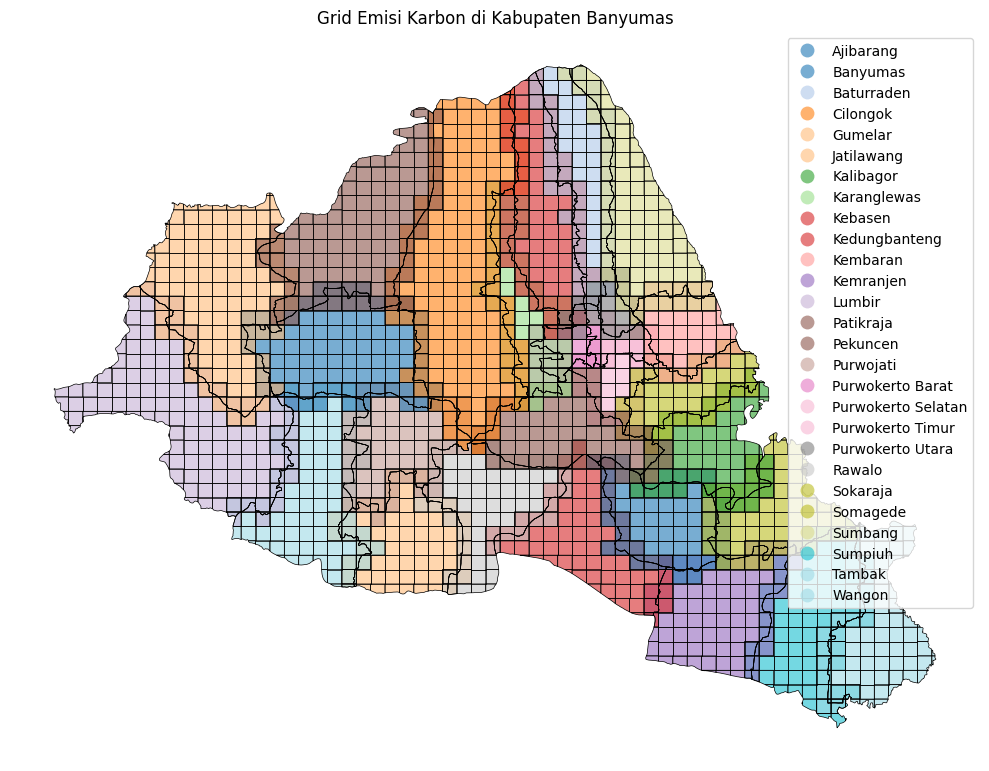

In [11]:
df_geo = gpd.read_file("D:/college_dump/PKL/PREDIKSI EMISI KARBON/grid_emisi_banyumas_kecamatan.geojson")

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
df_geo.boundary.plot(ax=ax, linewidth=0.5, color="black")
df_geo.plot(ax=ax, column="kecamatan", cmap="tab20", alpha=0.6, legend=True)
plt.title("Grid Emisi Karbon di Kabupaten Banyumas")
plt.axis("off")
plt.tight_layout()
plt.show()

DATA SPLITING DAN OVERSAMPLING

In [12]:
df = pd.read_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/data_emisi_banyumas_kecamatan.csv")

train_kecamatan = ["Purwokerto Selatan", "Purwokerto Barat", "Purwokerto Timur", "Baturraden", "Sokaraja"]
test_kecamatan = ["Kalibagor", "Somagede"]

# Tambah fitur rasio
df["rasio_hijau_bangunan"] = df["luas_hijau_m2"] / (df["luas_bangunan_m2"] + 1)
df["rasio_jalan_bangunan"] = df["panjang_jalan_m"] / (df["luas_bangunan_m2"] + 1)

# Split data
df_train = df[df["kecamatan"].isin(train_kecamatan)]
df_test  = df[df["kecamatan"].isin(test_kecamatan)]

# Fitur dan label
fitur = [
    "luas_hijau_m2", "luas_bangunan_m2", "panjang_jalan_m",
    "rasio_hijau_bangunan", "rasio_jalan_bangunan"
]
X_train = df_train[fitur]
y_train = df_train["kategori_emisi"]

X_test = df_test[fitur]
y_test = df_test["kategori_emisi"]

# Oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [13]:
# Label encoding
le = LabelEncoder()
y_resampled_encoded = le.fit_transform(y_resampled)
y_test_encoded = le.transform(y_test)

classes = le.classes_  # ['normal', 'parah', 'sedang']
class_indices = list(range(len(classes)))  # [0, 1, 2]

C:\Users\Adel\AppData\Local\Temp\ipykernel_1196\4014303838.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_before, x="kategori_emisi", palette="Blues", ax=axes[0])
C:\Users\Adel\AppData\Local\Temp\ipykernel_1196\4014303838.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_after, x="kategori_emisi", palette="Greens", ax=axes[1])


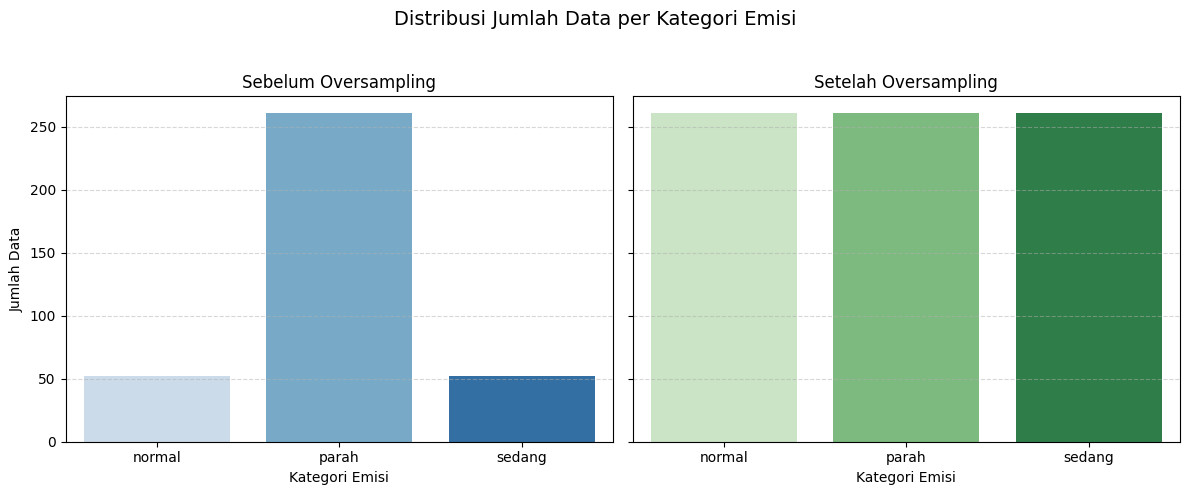

In [14]:
df_before = pd.DataFrame(X_train, columns=fitur)
df_before["kategori_emisi"] = y_train.values
df_before["status"] = "Sebelum Oversampling"

df_after = pd.DataFrame(X_resampled, columns=fitur)
df_after["kategori_emisi"] = y_resampled.values
df_after["status"] = "Setelah Oversampling"

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Sebelum normalisasi
sns.countplot(data=df_before, x="kategori_emisi", palette="Blues", ax=axes[0])
axes[0].set_title("Sebelum Oversampling")
axes[0].set_xlabel("Kategori Emisi")
axes[0].set_ylabel("Jumlah Data")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Setelah normalisasi
sns.countplot(data=df_after, x="kategori_emisi", palette="Greens", ax=axes[1])
axes[1].set_title("Setelah Oversampling")
axes[1].set_xlabel("Kategori Emisi")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle("Distribusi Jumlah Data per Kategori Emisi", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

TRAINING MODEL

Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

✅ Akurasi Prediksi Keseluruhan: 0.9859 (98.59%)

📋 Classification Report:
              precision    recall  f1-score   support

      normal       0.98      1.00      0.99        43
       parah       1.00      0.98      0.99        83
      sedang       0.98      0.99      0.98        87

    accuracy                           0.99       213
   macro avg       0.98      0.99      0.99       213
weighted avg       0.99      0.99      0.99       213



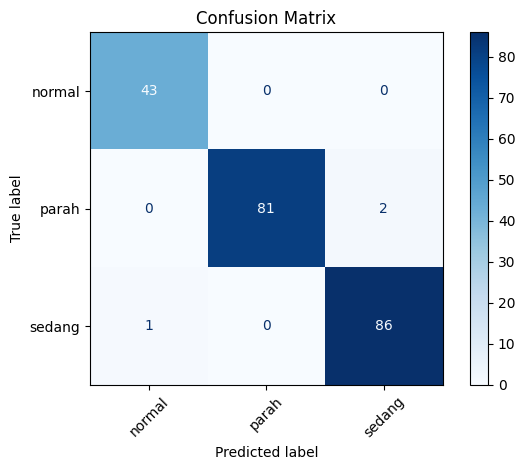

In [15]:
best_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}
grid = GridSearchCV(SVC(probability=True), best_params, cv=3)
grid.fit(X_resampled, y_resampled_encoded)

print("Best Params:", grid.best_params_)

# Kalibrasi model terbaik dari GridSearch
calibrated_model = CalibratedClassifierCV(grid.best_estimator_, cv=3, method="isotonic")
calibrated_model.fit(X_resampled, y_resampled_encoded)

# Prediksi & evaluasi
y_pred = calibrated_model.predict(X_test)
y_score = calibrated_model.predict_proba(X_test)

# Akurasi keseluruhan
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"\n✅ Akurasi Prediksi Keseluruhan: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

# Classification Report
print("📋 Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=classes))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_encoded, y_pred, display_labels=classes, cmap="Blues", xticks_rotation=45
)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


VISUALISASI ROC


 Evaluasi Binary Manual + ROC Curve per Kelas (threshold = 0.3):

🟨 Kelas 'normal' vs bukan_normal
              precision    recall  f1-score   support

bukan_normal       1.00      0.99      1.00       170
      normal       0.98      1.00      0.99        43

    accuracy                           1.00       213
   macro avg       0.99      1.00      0.99       213
weighted avg       1.00      1.00      1.00       213

🟨 Kelas 'parah' vs bukan_parah
              precision    recall  f1-score   support

 bukan_parah       0.98      1.00      0.99       130
       parah       1.00      0.98      0.99        83

    accuracy                           0.99       213
   macro avg       0.99      0.99      0.99       213
weighted avg       0.99      0.99      0.99       213

🟨 Kelas 'sedang' vs bukan_sedang
              precision    recall  f1-score   support

bukan_sedang       0.99      0.98      0.99       126
      sedang       0.98      0.99      0.98        87

    accuracy      

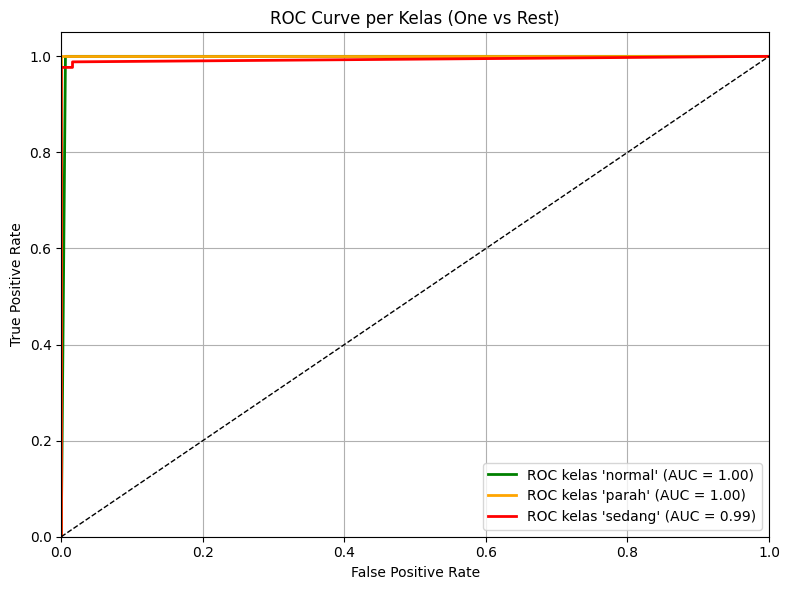

In [16]:
threshold = 0.3

print(f"\n Evaluasi Binary Manual + ROC Curve per Kelas (threshold = {threshold}):\n")

plt.figure(figsize=(8, 6))
colors = ['green', 'orange', 'red']
fpr = dict()
tpr = dict()
roc_auc = dict()

for i, label in enumerate(classes):
    proba = y_score[:, i]

    # ROC Curve
    y_true_binary = np.where(y_test_encoded == i, 1, 0)  # 1 = target, 0 = lainnya
    fpr[i], tpr[i], _ = roc_curve(y_true_binary, proba)
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f"ROC kelas '{label}' (AUC = {roc_auc[i]:.2f})")

    # Evaluasi threshold binary manual
    y_pred_manual = np.where(proba >= threshold, label, f"bukan_{label}")
    y_true_label = np.where(y_test_encoded == i, label, f"bukan_{label}")

    print(f"🟨 Kelas '{label}' vs bukan_{label}")
    print(classification_report(y_true_label, y_pred_manual))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Kelas (One vs Rest)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

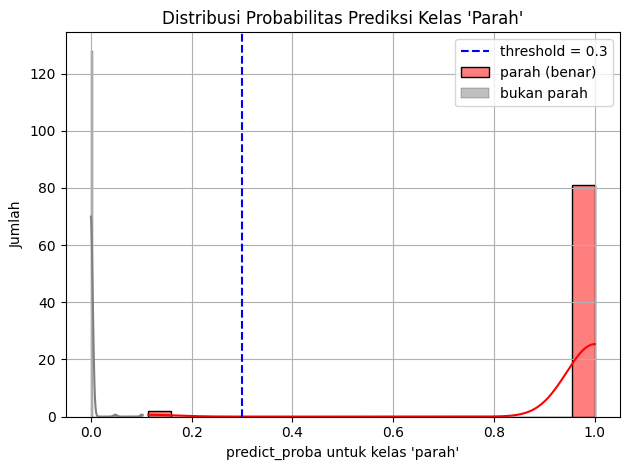

In [17]:
parah_index = list(classes).index("parah")

# Probabilitas prediksi untuk kelas 'parah'
probs = y_score[:, parah_index]

mask_parah = (y_test_encoded == parah_index)
mask_non_parah = (y_test_encoded != parah_index)

sns.histplot(probs[mask_parah], color='red', label="parah (benar)", bins=20, kde=True)
sns.histplot(probs[mask_non_parah], color='gray', label="bukan parah", bins=20, kde=True)
plt.axvline(threshold, color='blue', linestyle='--', label=f"threshold = {threshold}")
plt.title("Distribusi Probabilitas Prediksi Kelas 'Parah'")
plt.xlabel("predict_proba untuk kelas 'parah'")
plt.ylabel("Jumlah")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# Gabung prediksi
df_test["prediksi_kategori"] = y_pred

df_test.to_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/hasil_prediksi_MLP.csv", index=False)
print(" Prediksi disimpan ke: hasil_prediksi_SVM.csv")

 Prediksi disimpan ke: hasil_prediksi_SVM.csv


C:\Users\Adel\AppData\Local\Temp\ipykernel_1196\2999417632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediksi_kategori"] = y_pred


In [19]:
def rekap_prediksi_semua_kecamatan(df_grid, model):
    semua_kecamatan = df_grid["kecamatan"].unique()
    hasil_list = []

    luas_grid_m2 = 1_000_000

    df_grid["rasio_hijau_bangunan"] = df_grid["luas_hijau_m2"] / (df_grid["luas_bangunan_m2"] + 1)
    df_grid["rasio_jalan_bangunan"] = df_grid["panjang_jalan_m"] / (df_grid["luas_bangunan_m2"] + 1)

    for kec in semua_kecamatan:
        data_kec = df_grid[df_grid["kecamatan"] == kec]

        if data_kec.empty:
            continue

        X = data_kec[["luas_hijau_m2", "luas_bangunan_m2", "panjang_jalan_m", "rasio_hijau_bangunan", "rasio_jalan_bangunan"]]
        pred = model.predict(X)

        data_kec = data_kec.copy()
        data_kec["prediksi_kategori"] = pred

        # Rata-rata hasil
        kategori_dominan = data_kec["prediksi_kategori"].mode()[0]
        skor_emisi = data_kec["emisi_score"].mean() if "emisi_score" in data_kec.columns else None
        kepadatan_jalan = (data_kec["panjang_jalan_m"] / luas_grid_m2).mean() * 1000
        kepadatan_bangunan = (data_kec["luas_bangunan_m2"] / luas_grid_m2).mean()
        persentase_hijau = (data_kec["luas_hijau_m2"] / luas_grid_m2).mean() * 100

        hasil_list.append({
            "kecamatan": kec,
            "kategori_emisi": kategori_dominan,
            "rata_skor_emisi": skor_emisi,
            "kepadatan_jalan_km/km2": kepadatan_jalan,
            "kepadatan_bangunan_m2/km2": kepadatan_bangunan,
            "persentase_area_hijau": persentase_hijau
        })

    df_hasil = pd.DataFrame(hasil_list)

    df_hasil.to_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/rekap_prediksi_SVM.csv", index=False)
    print(f" Rekap prediksi berhasil disimpan")

    return df_hasil

In [20]:
df_grid = pd.read_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/data_emisi_banyumas_kecamatan.csv")
hasil_rekap = rekap_prediksi_semua_kecamatan(df_grid, calibrated_model)

 Rekap prediksi berhasil disimpan


In [21]:
df1 = pd.read_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/rekap_prediksi_SVM.csv")
df2 = pd.read_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/titik_kecamatan_banyumas.csv")

# Merge berdasarkan kolom kecamatan
gabung_df = pd.merge(df1, df2, on="kecamatan", how="inner")  # atau outer, left, right

gabung_df.to_csv("hasil_merge_SVM.csv", index=False)

In [22]:
df = pd.read_csv("D:/college_dump/PKL/PREDIKSI EMISI KARBON/hasil_merge_SVM.csv")

mapping = {
    0: "normal",
    1: "parah",
    2: "sedang"
}

df["kategori_emisi"] = df["kategori_emisi"].map(mapping)

df.to_csv("hasil_merge_SVM_labeled.csv", index=False)
print(df.head())

   kecamatan kategori_emisi  rata_skor_emisi  kepadatan_jalan_km/km2  \
0     Lumbir         normal     -4454.673789                0.744858   
1    Gumelar         sedang     -4153.856938                0.966444   
2     Wangon         sedang     -3023.849190                1.204302   
3  Ajibarang         sedang     -2608.399787                1.401562   
4   Pekuncen         normal     -3757.069669                1.280040   

   kepadatan_bangunan_m2/km2  persentase_area_hijau  latitude   longitude  
0                   0.056013              44.885051 -7.465615  108.975399  
1                   0.078569              42.012884 -7.388697  108.996527  
2                   0.092306              30.795942 -7.512976  109.054098  
3                   0.121228              26.815569 -7.425407  109.072875  
4                   0.085234              38.085943 -7.348280  109.083898  
